In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import cv2 as cv
from skimage.segmentation import slic

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment
import findatree.object_properties as obj_props

importlib.reload(segment)

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define raster-files and print infos

In [63]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
file_names.extend(['Tnr_12702_D-20210713_DSM.tif'])
file_names.extend(['tnr_12702_dtm.tif'])
file_names.extend(['Tnr_12702_2021_Ortho.tif'])

# file_names.extend(['Tnr_11044_D-20210707_DSM.tif'])
# file_names.extend(['tnr_11044_dtm.tif'])
# file_names.extend(['Tnr_11044_2021_Ortho.tif'])

# file_names.extend(['Tnr_11626_D-20210719_DSM.tif'])
# file_names.extend(['tnr_11626_dtm.tif'])
# file_names.extend(['Tnr_11626_2021_Ortho.tif'])

paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

io.print_raster_info(paths)


(0)
Name: C:/Data/lwf/DSM_2021/Tnr_12702_D-20210713_DSM.tif
Width[px]: 4749
Height[px]: 4626
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-32767.0,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=661774.3636313608, bottom=5470426.000381344, right=662196.9573473627, top=5470837.648840014)
Affine geo-transfrom: [0.08898583196501086, 0.0, 661774.3636313608, 0.0, -0.0889858319649575, 5470837.648840014]

(1)
Name: C:/Data/lwf/DTM/tnr_12702_dtm.tif
Width[px]: 398
Height[px]: 409
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-3.4028234663852886e+38,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=661789.9361519547, bottom=5470428.936913799, right=662187.9361519547, top=5470837.936913799)
Affine geo-transfrom: [1.0, 0.0, 661789.9361519547, 0.0, -1.0, 5470837.936913799]

(2)
Name: C:/Data/lwf/Orthophotos_2021/Tnr_12702_2021_Ortho.tif
Width[px]: 7913
Height[px]: 8617
No. of rasters: 5
  Index: 1, dtype: uint16


### Reproject raster-files to same area & resolution

In [64]:
importlib.reload(io)
res = 0.2
bands, mask, A, bound = io.reproject_all_intersect(paths, res=res)

C:\Users\flori\Anaconda3\envs\findatree_v01\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Define and normalize channels

In [65]:
importlib.reload(io)

cs_prim = {
    'dsm': bands[0][:,:,0],
    'dtm': bands[1][:,:,0],
    'blue': bands[2][:,:,0],
    'red': bands[2][:,:,1],
    'green': bands[2][:,:,2],
    're': bands[2][:,:,3],
    'nir': bands[2][:,:,4],
}

### Segmentation -> Objects
#### (1) Define and normalize channels for segmentation

In [66]:
reduce = 1
cs_segment, shape = io.define_channels(cs_prim, reduce=reduce)

res_segmentation = res * 2**reduce
print(f"Resolution of images: {res_segmentation:.1f} [m]")
print(f"Shape of images: {shape} [px]")

Resolution of images: 0.4 [m]
Shape of images: (997, 916) [px]


#### (2) Global mask and local mask by adaptive gaussian thresholding

In [67]:
importlib.reload(segment)

# Rough global mask of positives
mask_global = (cs_segment['chm'] > 3) & (cs_segment['ndvi'] > 0.4)

# Local mask of positives by adaptive thresholding within distance
img =cs_segment['l'].copy()
distance = 20 / res_segmentation
mask_local = segment.local_thresholding(img, mask_global, distance)

Distance set to: 51 [px]


#### (3) Iterative shrinking of local mask and expansion of labels

In [68]:
importlib.reload(segment)

# Iterative: Shrink mask & expand labels
thresh_dist_start = 5 / res_segmentation
labels, bounds, mask_seed = segment.shrinkmask_expandlabels_iter(
    mask_local,
    thresh_dist_start=thresh_dist_start,
    )

#### (4) Plot segmentation results

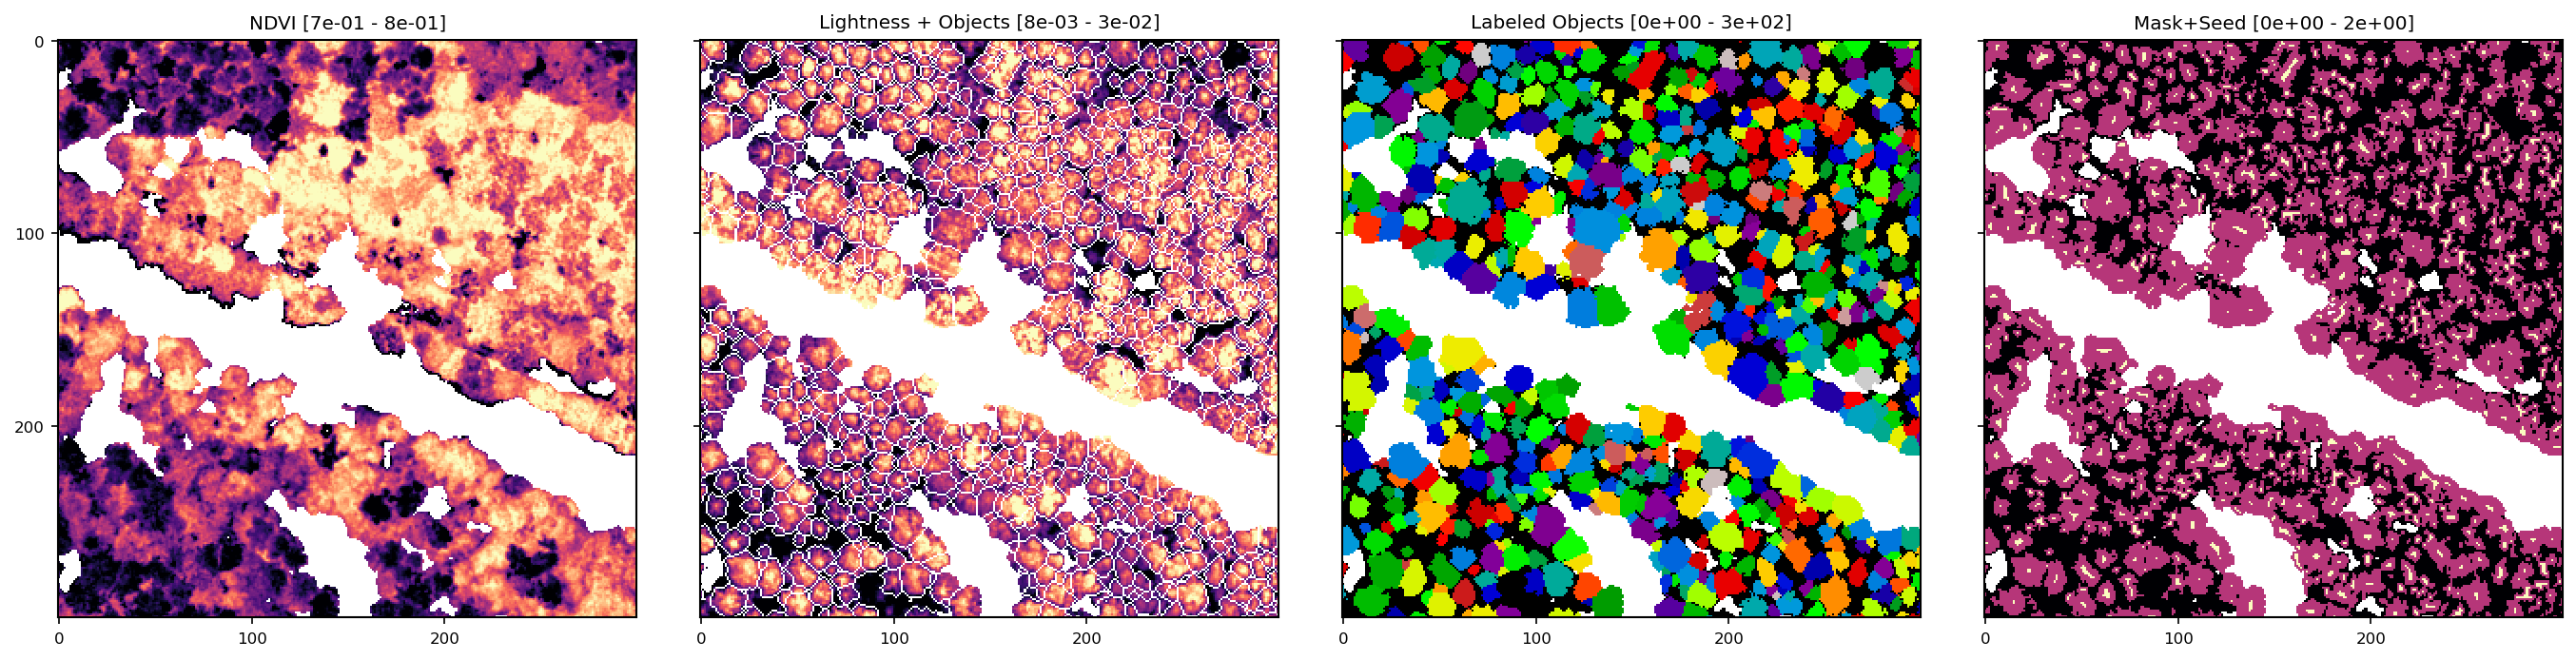

In [69]:
importlib.reload(visual)

segment_result = img.copy()
segment_result[bounds == 1] = np.nan

channels = [
    cs_segment['ndvi'], segment_result, labels, mask_seed, 
]
use_random_cmap = [False, False, True, False]
channels_names = ['NDVI', 'Lightness + Objects', 'Labeled Objects', 'Mask+Seed']
contrasts = [None, None, None, None]
xylim = [(500, 150), (500, 150)]

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    mask=mask_global,
    contrasts=contrasts,
    use_random_cmap=use_random_cmap,
    channel_names=channels_names,
    zoom=1.5,
    # n_cols_rows=(2,2),
)

### Object properties

In [70]:
importlib.reload(io)

reduce = 0
cs, shape = io.define_channels(cs_prim, reduce=reduce)

res_final = res * 2**reduce
print(f"Resolution of images: {res_final:.1f} [m]")
print(f"Shape of images: {shape} [px]")

Resolution of images: 0.2 [m]
Shape of images: (1994, 1831) [px]


In [71]:
importlib.reload(segment)
importlib.reload(obj_props)

labels_hr = segment.labels_resize(labels, shape=shape)
bounds_hr = segment.labels_to_bounds(labels_hr)

In [72]:
import skimage.measure as measure
props = measure.regionprops(labels_hr, cs['l'])
keys = [key for key in props[0]]

props_table = measure.regionprops_table(
    labels_hr,
    cs['ndvi'],
    properties=keys,
    )

props_df = pd.DataFrame(props_table)

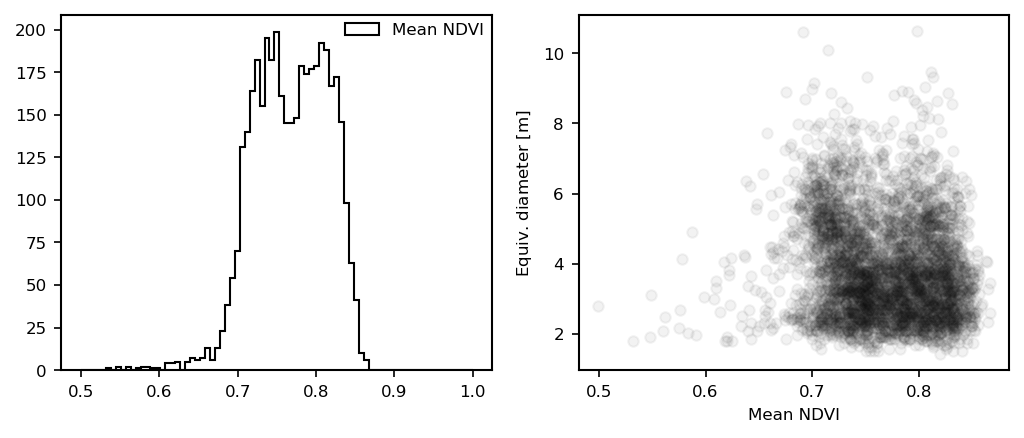

In [84]:
bins = np.linspace(0.5,1, 80)

f, axs = plt.subplots(ncols=2, figsize=[8,3])

ax = axs[0]
_ = ax.hist(
    props_df['intensity_mean'],
    bins=bins,
    histtype='step',
    label='Mean NDVI'
    )
ax.legend()

ax = axs[1]
_ = ax.scatter(
    props_df['intensity_mean'],
    props_df['equivalent_diameter_area'] * res_final,
    alpha=0.05,
    )
_ = ax.set_xlabel('Mean NDVI')
_ = ax.set_ylabel(r'Equiv. diameter [$m$]')

In [74]:
# i = np.random.randint(0,len(props))
# # i = 2593
# print(i)
# prop = props[i]

# mask = prop['image_filled']
# slice = prop['slice']

# l = prop['image_intensity']
# ndvi = cs['ndvi'][slice] * mask

# channels = [mask, l, ndvi]
# contrasts = [(0,1), (1e-3, 3.5e-2), (0.5,1)]
# channel_names = ['Mask', 'L' , 'NDVI']


# f, axs = visual.show_channels(
#     channels,
#     contrasts=contrasts,
#     channel_names=channel_names,
#     zoom=0.8,
# )

# y,x = prop['centroid_local']
# yw,xw = prop['centroid_weighted_local']
# _ = axs[1].scatter(x, y, s=20, marker='o', fc='w', ec='k')
# _ = axs[1].scatter(xw, yw, s=40, marker='s', fc='none', ec='k')


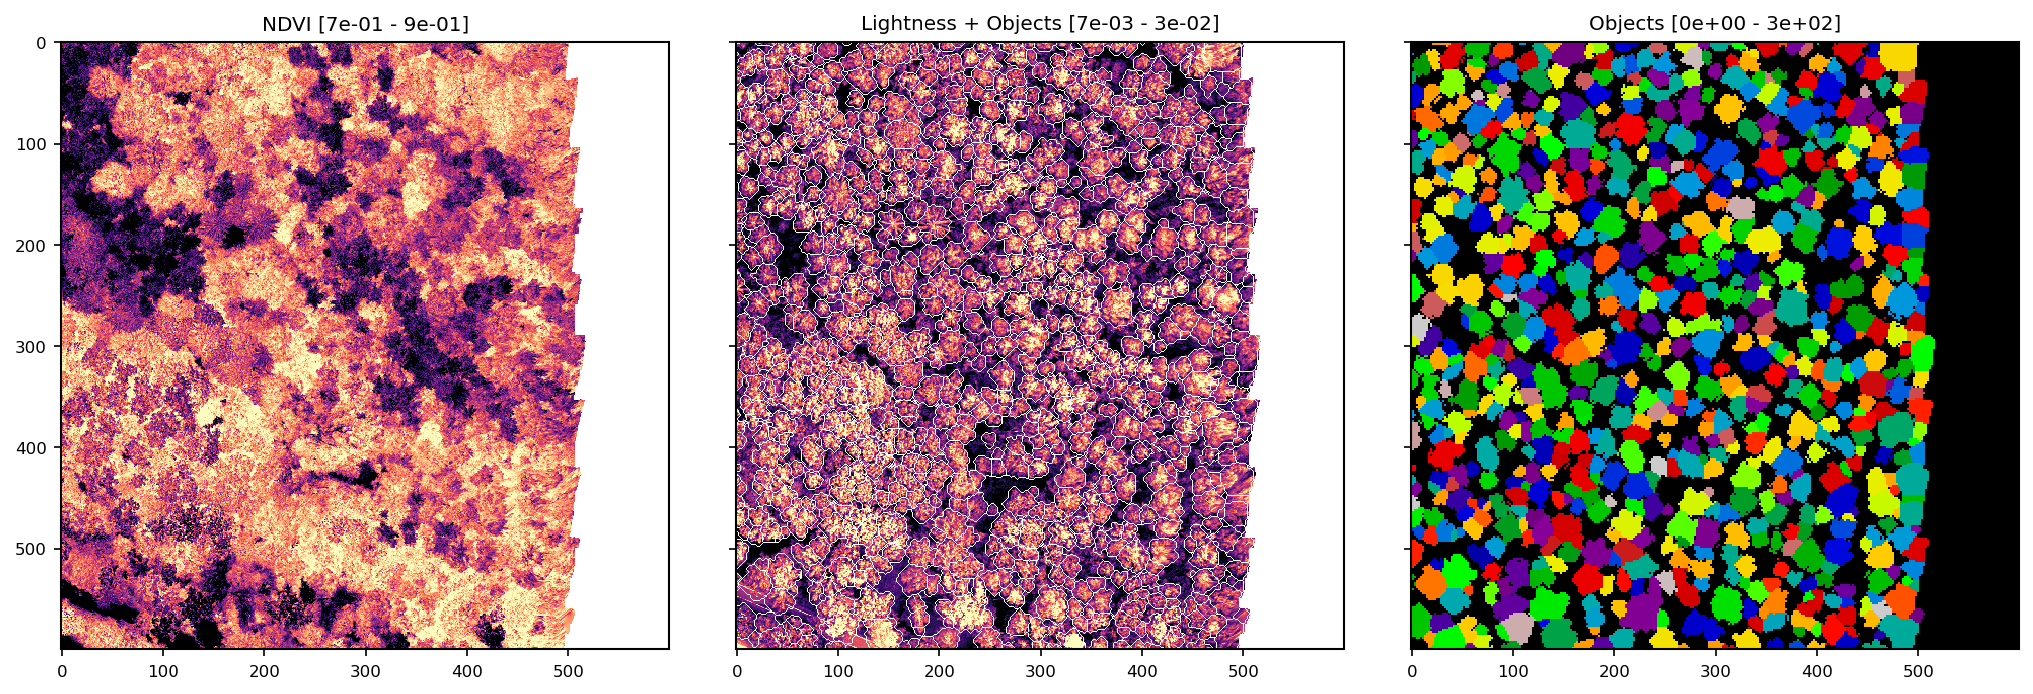

In [75]:
segment_result_hr = cs['l'].copy()
segment_result_hr[bounds_hr == 1] = np.nan

channels = [
    cs['ndvi'], segment_result_hr, labels_hr,
]
use_random_cmap = [False, False, True]
channels_names = ['NDVI', 'Lightness + Objects', 'Objects' ]
contrasts = [None, None, None]
xylim = [(1500,300), (800,300)]

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    # mask=mask_global,
    contrasts=contrasts,
    use_random_cmap=use_random_cmap,
    channel_names=channels_names,
    zoom=1.5,
    # n_cols_rows=(2,2),
)